In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

2023-01-24 14:50:24.277258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 14:50:25.047443: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-24 14:50:25.047470: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-24 14:50:27.305861: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

### Paths

- celeba_path: path to the directory with 224x224 cropped pictures from celebA dataset
- https://drive.google.com/drive/folders/1taLMxwqjBbjGWLGJfC5ngJnNHDX_UOJr?usp=sharing

In [3]:
celeba_path = Path('../../Dataset/img_celeba_cropped/')
celeba_identity_path = Path('../../Dataset/celeb_identity_processed.txt')

precalculated_pairs_path = Path('../../Dataset/pairs_precalculated.csv')

### Hyperparameters

- Hyperparameters used in this model

In [4]:
pair_count = 1000
train_size = 0.7

network_input_shape = (224, 224, 3)

batch_size = 16
margin = 0.5
lr = 1e-4

### Creating pairs

- load celeba_identity_path dataset with the information about the dataset

In [5]:
df_identity = pd.read_csv(
    celeba_identity_path,
    sep=",",
    names=["image", "identity"],
    header=0,
    dtype=str
)

In [6]:
def create_n_pairs(df_identity, n):
    pairs = []

    for pair in range(n):
        anchor_id = df_identity['identity'].sample(1, replace=True).to_string(index=False)

        keepGoing = True
        while (keepGoing):
            anchor, positive = df_identity.loc[df_identity['identity'] == anchor_id]['image'].sample(2, replace=True)
            keepGoing = (anchor == positive)

        negative = df_identity.loc[df_identity['identity'] != anchor_id]['image'].sample(1, replace=True).to_string(index=False)

        anchor = str(celeba_path) + '/' + anchor
        positive = str(celeba_path) + '/' + positive
        negative = str(celeba_path) + '/' + negative

        pairs.append([anchor, positive, 1])
        pairs.append([anchor, negative, 0])

    return pd.DataFrame(pairs, columns=['left', 'right', 'label'])

- creating n-pair dataframe

In [ ]:
pairs = create_n_pairs(df_identity, pair_count)
pairs.head()

In [8]:
pairs.shape

(2000, 3)

### Visualize pairs

- first 8 pairs of the generated dataset
- even indeces are same people, odd are the different ones

In [23]:
def visualize_pairs(pairs):
    def show(ax, path):
        img = cv2.imread(path)

        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(5, 15))

    axs = fig.subplots(8, 2)
    for i in range(8):
        show(axs[i, 0], pairs.iloc[i][0])
        show(axs[i, 1], pairs.iloc[i][1])

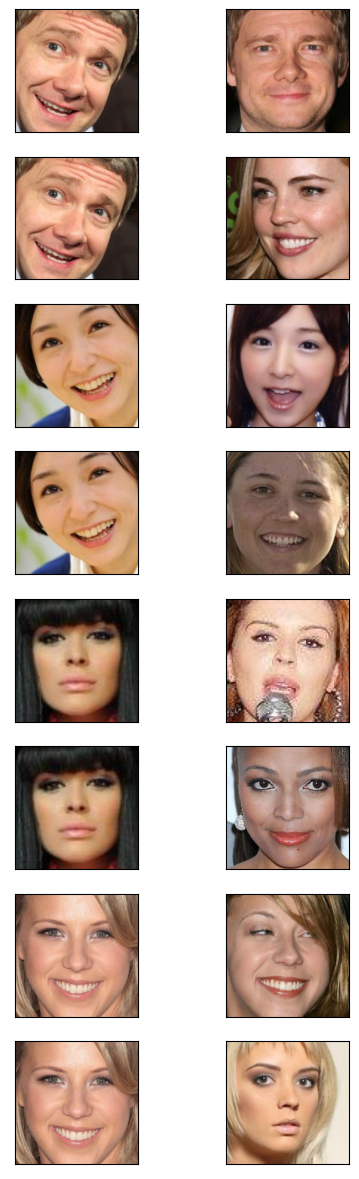

In [10]:
visualize_pairs(pairs)

### TF Pipeline

- VGG_FACE requires numpy array as an input, therefore TF API functions for preprocessing is not used in this case

In [27]:
# reshape flag expands dimension of the img, needed for model.predict
def convert_to_img(img_path, reshape=False):
    img = cv2.imread(img_path)
    img = img.astype("float32")
    img = preprocess_input(img, version=2)

    if reshape is True:
        img = img[np.newaxis, ...]

    return img


def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [28]:
def create_dataset(df, for_prediction=False):

    left = df["left"].apply(convert_to_img, reshape=for_prediction)
    right = df["right"].apply(convert_to_img, reshape=for_prediction)
    left = left.tolist()
    right = right.tolist()

    feature_ds = tf.data.Dataset.from_tensor_slices((left, right))

    labels_ds = tf.data.Dataset.from_tensor_slices(df['label'].values)
    labels_ds = labels_ds.map(label_preprocessing)

    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))

    return dataset

In [13]:
dataset = create_dataset(pairs)

In [14]:
train_ds = dataset.take(round(pair_count * train_size))
val_ds = dataset.skip(round(pair_count * train_size))

### Performance optimization

- batching, batch size 16, parallel calls set to AUTOTONE
- prefetching buffer size set to AUTOTUNE as well
- pictures are cached in memory

In [15]:
train_ds = train_ds \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

val_ds = val_ds \
        .batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE) \
        .prefetch(buffer_size=tf.data.AUTOTUNE) \
        .cache()

# Training a new model

### VGG_FACE embedding

- keras vgg_face model used are a feature extractor
- feature vector is 512 neurons wide. 256 FV was giving worse performance, however increasing the FV width to 1024 did not show any significant improvements
- adding more layers with non-linear activation did not improve performance
- adding batch normalization layer did not improve performance as well

In [12]:
def vgg_face_tower():
    input = layers.Input(network_input_shape)

    base = VGGFace(
        input_tensor=input,
        model="resnet50",
        input_shape=network_input_shape,
        include_top=False
    )

    for layer in base.layers:
        layer.trainable = False

    model = layers.Flatten()(base.output)

    output = layers.Dense(512)(model)

    return Model(input, output, name="vgg_face_tower")

In [13]:
feature_extractor = vgg_face_tower()

In [14]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [15]:
# initializing the left "tower"
left_tower_input = layers.Input(
    shape=network_input_shape,
    name="left_tower"
)

left_tower = feature_extractor(left_tower_input)


# initializing the right "tower"
right_tower_input = layers.Input(
    shape=network_input_shape,
    name="right_tower"
)

right_tower = feature_extractor(right_tower_input)


# merge layer
merge_layer = layers.Lambda(
    euclidean_distance,
    name="lambda_layer"
)([left_tower, right_tower])


model = Model([left_tower_input, right_tower_input], merge_layer, name="contrastive_loss_model")

In [16]:
def cont_loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

- CL margin of 0.5 seems to be have higher performance by 2-3 percent compared to margin loss 1 or 0.2
- optimal learning rate of 1e-4 was chosen as it does not cause model to overfit and training is significatnly faster compared to lr of 1e-5

In [17]:
model.compile(loss=cont_loss(margin), optimizer=Adam(learning_rate=lr))
model.summary()

Model: "contrastive_loss_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg_face_tower (Functional)    (None, 512)          24610240    ['left_tower[0][0]',             
                                                                  'right_towe

In [124]:
# plot_model(model, show_shapes=True)

### Callbacks

- early stopping and lr_scheduler_reduce used when training on a large number of epochs so the model

In [125]:
tensorboard = TensorBoard(
    log_dir=f"logs/{model.name}_{time.strftime('run_%Y_%m_%d-%H_%M_%S')}",
    # histogram_freq=1,
    # embeddings_freq=1,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

lr_scheduler_reduce = ReduceLROnPlateau(factor=0.5, patience=5)

In [126]:
callbacks_list = [
    early_stopping,
    lr_scheduler_reduce,
]

In [127]:
%time
model_fit = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks_list,
    epochs=50,
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.7 µs
Epoch 1/50
44/44 [==============================] - 16s 273ms/step - loss: 1463.5649 - val_loss: 1940.3975 - lr: 1.0000e-04
Epoch 2/50
44/44 [==============================] - 10s 241ms/step - loss: 1130.5460 - val_loss: 1780.9174 - lr: 1.0000e-04
Epoch 3/50
44/44 [==============================] - 10s 241ms/step - loss: 932.8206 - val_loss: 1666.0912 - lr: 1.0000e-04
Epoch 4/50
44/44 [==============================] - 10s 242ms/step - loss: 787.3124 - val_loss: 1578.9036 - lr: 1.0000e-04
Epoch 5/50
44/44 [==============================] - 11s 244ms/step - loss: 675.0117 - val_loss: 1510.0297 - lr: 1.0000e-04
Epoch 6/50
44/44 [==============================] - 11s 244ms/step - loss: 585.4191 - val_loss: 1453.9979 - lr: 1.0000e-04
Epoch 7/50
44/44 [==============================] - 11s 245ms/step - loss: 512.2053 - val_loss: 1407.3889 - lr: 1.0000e-04
Epoch 8/50
44/44 [==============================] - 11s 246ms/step - loss

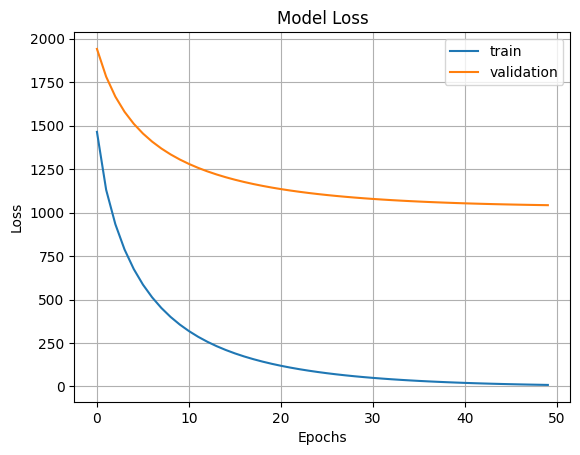

In [128]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

### Save model

- this script allows us to save either the whole model or just the embedding for feature extraction

In [18]:
save_path = 'saved_models'

#### Save whole model

In [ ]:
model_version = f'{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'{save_path}/{model_version}'
model.save(model_path)
model.save_weights("model_path")

#### Saving just the embedding for feature extraction

In [20]:
model_version = f'embedding-{model.name}-{time.strftime("%Y%m%d-%H%M%S")}'

model_path = f'{save_path}/{model_version}'
feature_extractor.save(model_path, include_optimizer=False)
feature_extractor.save_weights("model_path")

INFO:tensorflow:Assets written to: saved_models/embedding-contrastive_loss_model-20230124-091359/assets


INFO:tensorflow:Assets written to: saved_models/embedding-contrastive_loss_model-20230124-091359/assets


# b) Loading saved model

In [7]:
!ls ./saved_models

embedding-90-cutoff-47.54  full_model-87-cutoff-39.70
embedding_56.50_final	   full_model_56.50_final


#### Loading whole model

- loading contrastive_loss as a custom object

In [18]:
model = load_model('saved_models/full_model_56.50_final',
                   custom_objects={'contrastive_loss': cont_loss})

In [19]:
feature_extractor = load_model('saved_models/embedding_56.50_final')

## Tensorboard

- launching tensorboard straight from the notebook

In [32]:
# %load_ext tensorboard
# %tensorboard --logdir=logs

# Predictions

- prediction cutoff will be calculated from 500 random pairs

In [20]:
test_pairs = create_n_pairs(df_identity, 500)

In [21]:
test_pairs.head(6)

left  \
0  ../../Dataset/img_celeba_cropped/102352.jpg   
1  ../../Dataset/img_celeba_cropped/102352.jpg   
2  ../../Dataset/img_celeba_cropped/022539.jpg   
3  ../../Dataset/img_celeba_cropped/022539.jpg   
4  ../../Dataset/img_celeba_cropped/004727.jpg   
5  ../../Dataset/img_celeba_cropped/004727.jpg   

                                         right  label  
0  ../../Dataset/img_celeba_cropped/098662.jpg      1  
1  ../../Dataset/img_celeba_cropped/014073.jpg      0  
2  ../../Dataset/img_celeba_cropped/137498.jpg      1  
3  ../../Dataset/img_celeba_cropped/097330.jpg      0  
4  ../../Dataset/img_celeba_cropped/138921.jpg      1  
5  ../../Dataset/img_celeba_cropped/000087.jpg      0

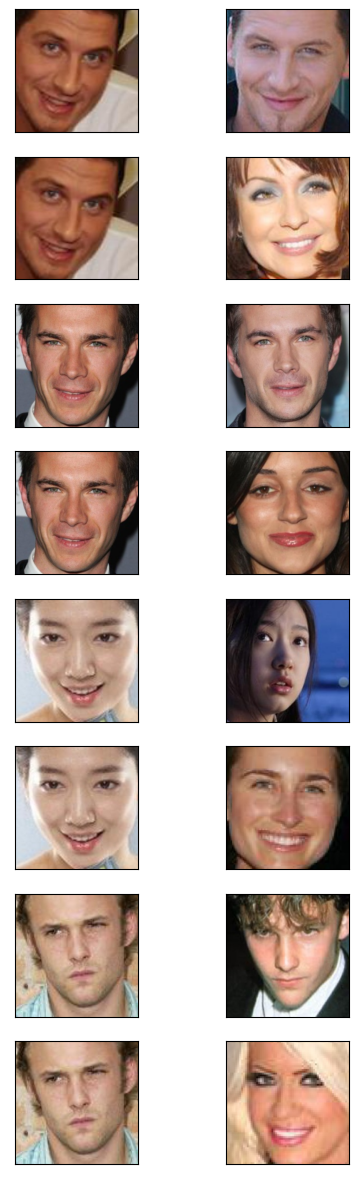

In [24]:
visualize_pairs(test_pairs)

- converting random pairs into the TF dataset
- for_prediction flag set to True (img will have one extra dimentsion necessary for `model.predict`)

In [29]:
test_ds = create_dataset(test_pairs, for_prediction=True)
test_labels = test_pairs['label']

2023-01-24 14:55:22.739752: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.
2023-01-24 14:56:17.768953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.


- euclidian distances as predictions

In [30]:
predictions = model.predict(test_ds)

2023-01-24 14:57:13.280356: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.
2023-01-24 14:57:13.831130: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 602112000 exceeds 10% of free system memory.


1000/1000 [==============================] - 107s 105ms/step


- separate positive and negative pair distances

In [32]:
positive_distances = predictions[0::2].flatten()
negative_distances = predictions[1::2].flatten()

- count and compare positive and negative distances distributions
- middle point between positive and megative distances mean is selected as a cutoff for predictions
- dist < cutoff => Same
- dist > cutoff => Different

In [33]:
positive_mean = pd.Series(positive_distances).mean()
pd.Series(positive_distances).describe()

count    500.000000
mean      46.056786
std        9.413305
min        3.036993
25%       39.824612
50%       45.989592
75%       52.336075
max       78.284973
dtype: float64

In [34]:
negative_mean = pd.Series(negative_distances).mean()
pd.Series(negative_distances).describe()

count    500.000000
mean      65.499321
std        5.085399
min       49.545563
25%       62.200142
50%       65.360321
75%       68.567247
max       80.331619
dtype: float64

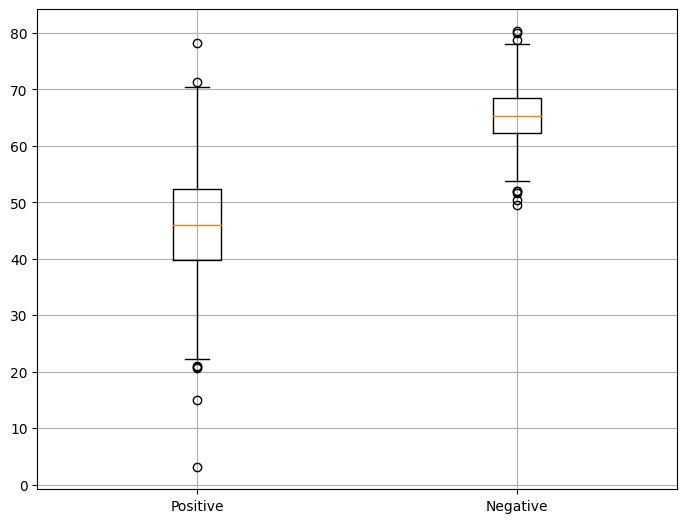

In [35]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.boxplot([positive_distances, negative_distances])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [36]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred.flatten() < cutoff
    return np.mean(pred == y_true), pred

In [37]:
cutoff = (positive_mean + negative_mean)/2
cutoff

55.778053283691406

### Model accuracy
- how well the selected cutoff separates between positive and negative pairs

In [38]:
test_accuracy, y_pred = compute_accuracy(test_labels, predictions, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 91.60%


<AxesSubplot: >

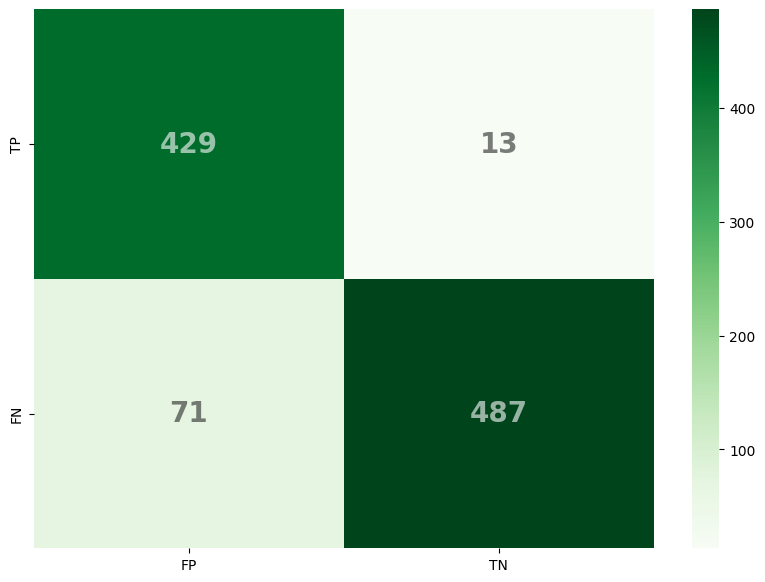

In [39]:
c_matrix = confusion_matrix(y_pred, test_labels, labels=[1, 0])
c_matrix_df = pd.DataFrame(c_matrix, index=["TP", "FN"], columns=["FP", "TN"])
plt.figure(figsize=(10, 7))
sn.heatmap(c_matrix_df, cmap="Greens", annot=True,
           annot_kws={'fontsize': 20, 'fontweight': 'bold', 'alpha': 0.6},
           fmt='g')

### Classification report with extra metrics

In [40]:
report = classification_report(y_pred, test_labels)
print(report)

              precision    recall  f1-score   support

       False       0.97      0.87      0.92       558
        True       0.86      0.97      0.91       442

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



### Visualize the predictions

In [41]:
def visualize(pairs, labels, cutoff, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {}".format('Same' if labels.iloc[i] == 1 else 'Different',
                                                      'Same' if predictions[i][0] < cutoff else 'Different'))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

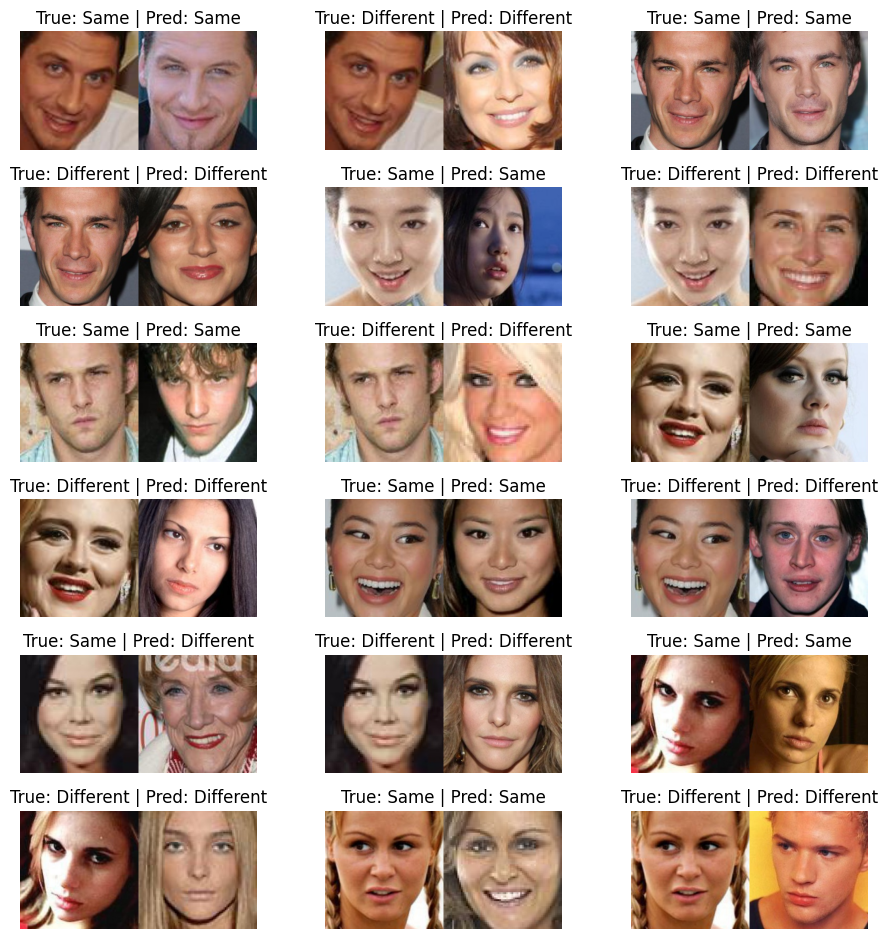

In [42]:
visualize(
    test_pairs,
    test_pairs['label'],
    cutoff,
    to_show=18,
    num_col=3,
    predictions=predictions,
    test=True
)

## Live Demo
Using our photos to extract features and then predicting identity computing the distance metric.

In [82]:
team_photos_path_left = "./team_photos_preprepared/"
team_photos_path_right = "./team_photos_live/"

team_photos_left = os.listdir(team_photos_path_left)
team_photos_right = os.listdir(team_photos_path_right)

team_photos_left = [team_photos_path_left + x for x in team_photos_left]
team_photos_right = [team_photos_path_right + x for x in team_photos_right]

In [83]:
def get_features_vector(extractor, photos):
    """ Function returns extracted features in a list for each given photo identified by a path. """
    results = []
    print(photos)
    processed_photos = map(lambda x: convert_to_img(x, True), photos)

    for photo in processed_photos:
        features = extractor.predict(photo)
        results.append(features)

    return results

In [84]:
team_photos_left_features = get_features_vector(feature_extractor, team_photos_left)
team_photos_right_features = get_features_vector(feature_extractor, team_photos_right)

['./team_photos_preprepared/20.jpg', './team_photos_preprepared/22.jpg', './team_photos_preprepared/24.jpg', './team_photos_preprepared/3.jpg', './team_photos_preprepared/5.jpg']
1/1 [==============================] - 0s 83ms/step
['./team_photos_live/3.jpg', './team_photos_live/4.jpg', './team_photos_live/1.jpg', './team_photos_live/2.jpg', './team_photos_live/6.jpg']
1/1 [==============================] - 0s 111ms/step


In [85]:
def find_best_match(reference_fv, list_of_fvs):
    best_match_index = None
    best_match_float = None

    for i in range(0, len(list_of_fvs)):
        distance = euclidean_distance((reference_fv, list_of_fvs[i]))
        distance_float = distance.numpy()[0][0]

        if not best_match_float or best_match_float > distance_float:
            best_match_index = i
            best_match_float = distance_float
        else:
            continue

    return best_match_index

In [86]:
def visualize_dict(dict_to_visualize):
    num_row = len(dict_to_visualize)
    cols = 2
    to_show = num_row
    i = 0

    fig, axes = plt.subplots(to_show, cols, figsize=(15, 15))

    for i, (key, value) in enumerate(dict_to_visualize.items()):
        ax1 = axes[i, 0]
        ax2 = axes[i, 1]

        ax1.imshow(cv2.cvtColor(cv2.imread(key), cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(cv2.imread(value), cv2.COLOR_BGR2RGB))

        ax1.set_xticklabels([])
        ax2.set_yticklabels([])
        ax1.set_axis_off()
        ax2.set_axis_off()

    plt.tight_layout()

    plt.show()

In [87]:
predicted_pairs_dict = {}

for n in range(0, len(team_photos_left_features)):
    predicted_match = find_best_match(team_photos_left_features[n], team_photos_right_features)
    predicted_pairs_dict[team_photos_left[n]] = team_photos_right[predicted_match]

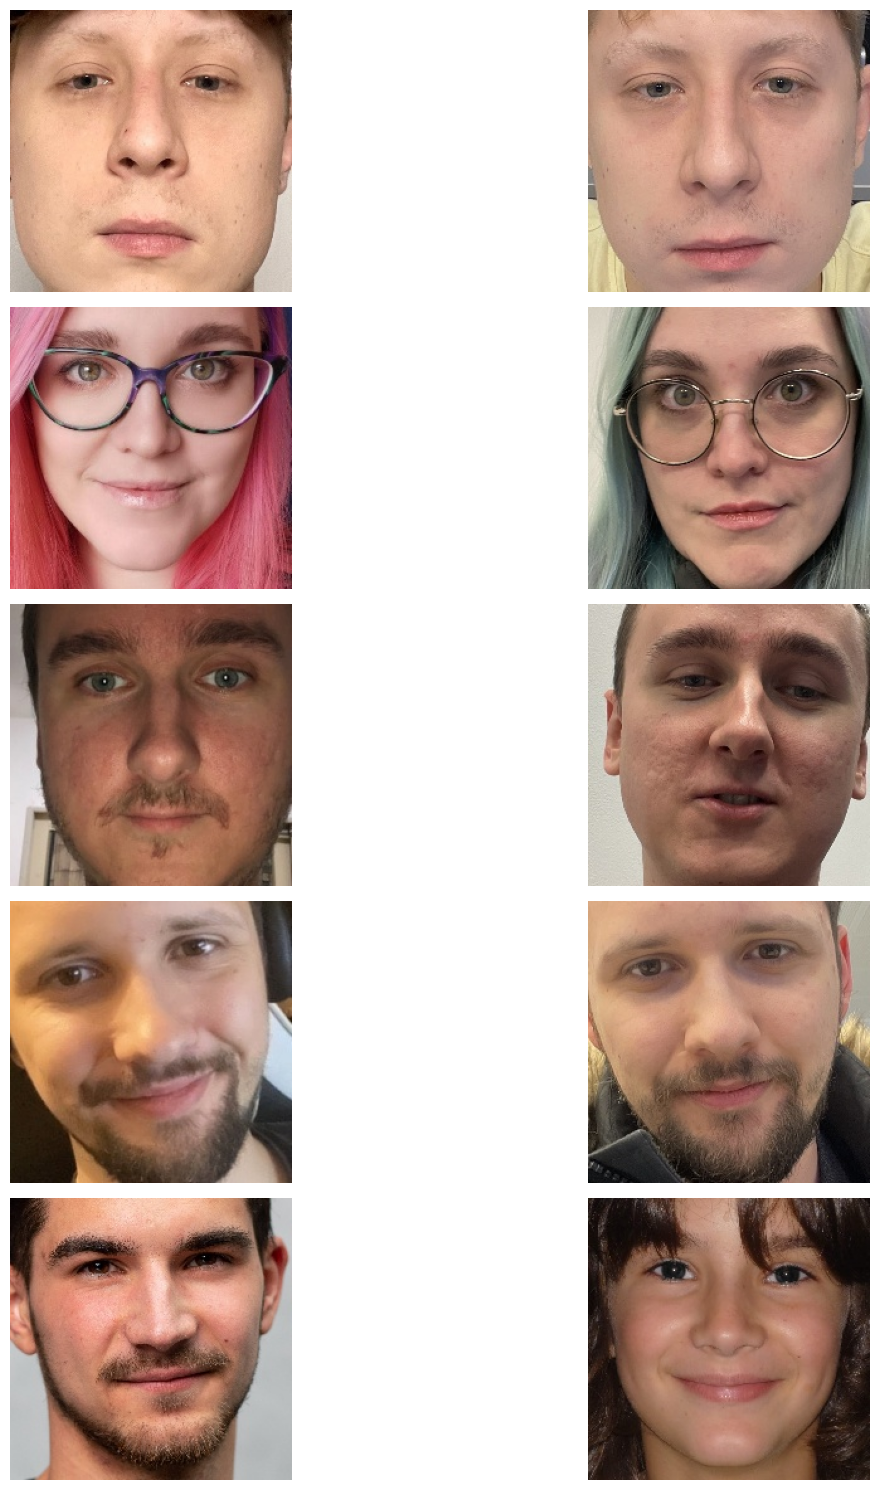

In [88]:
visualize_dict(predicted_pairs_dict)

In [89]:
def get_distances(reference_fv, list_of_fvs):
    distances = []

    for i in range(0, len(list_of_fvs)):
        distance = euclidean_distance((reference_fv, list_of_fvs[i]))
        distances.append(distance.numpy()[0][0])

    return distances

In [90]:
def visualize_differences(reference_photo, distances, photos, cutoff):
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 10001)
    gs.update(wspace=0.2)
    cell = 0

    for i in range(0, len(photos)):
        ax = fig.add_subplot(gs[0, cell:cell+2000], )
        ax.imshow(cv2.cvtColor(cv2.imread(photos[i]), cv2.COLOR_BGR2RGB))
        ax.set_title("{:0.5f}".format(distances[i]))

        ax.set_xticklabels([])
        ax.set_axis_off()

        cell += 2000

    ax2 = fig.add_subplot(gs[1, :])
    ax2.imshow(cv2.cvtColor(cv2.imread(reference_photo), cv2.COLOR_BGR2RGB))
    ax2.set_title("Reference image")
    ax2.set_xticklabels([])
    ax2.set_axis_off()

    fig.suptitle("Cutoff: {:0.5f}".format(cutoff), horizontalalignment='center')

    plt.show()

In [95]:
reference_photo = team_photos_left[4]
reference_fv = team_photos_left_features[4]
distances = get_distances(reference_fv, team_photos_right_features)

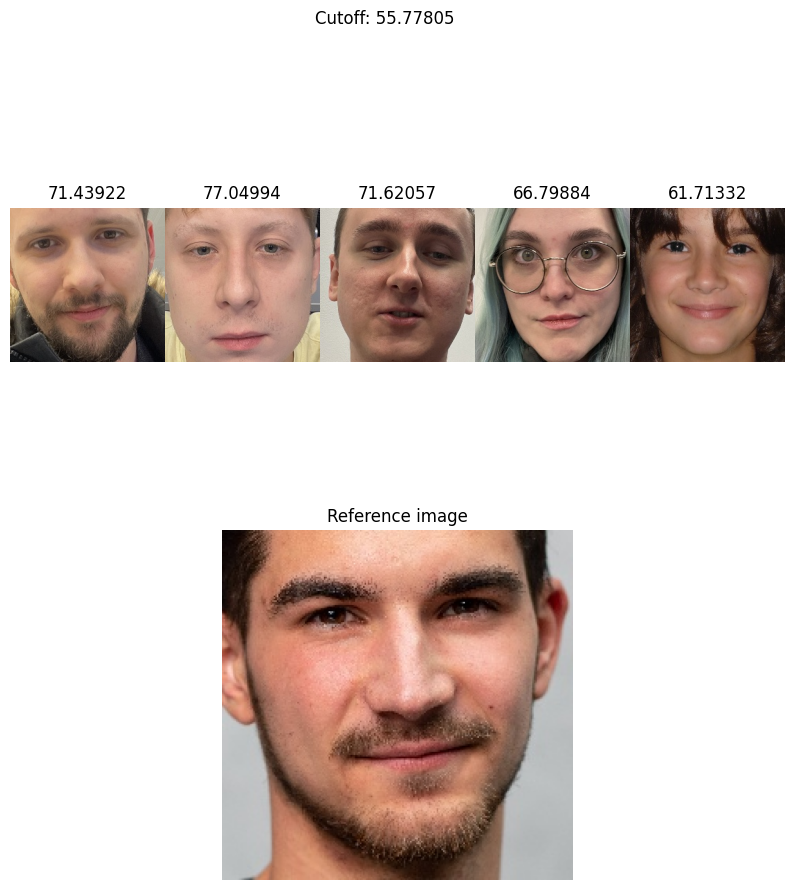

In [96]:
visualize_differences(reference_photo, distances, team_photos_right, cutoff)